# Project Title:Taxi Demand Forecasting for Sweet Lift: A Time Series Prediction Project

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data_resampled= data['num_orders'].resample('1H').sum()
data_resampled

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [5]:
data_resampled = data_resampled.dropna()
data_resampled

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

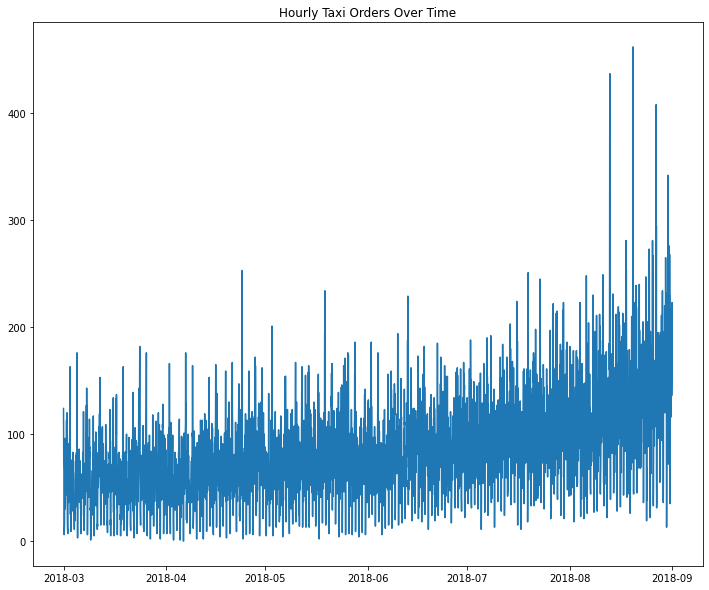

In [6]:
# Data Exploration
plt.figure(figsize=[12, 10])
plt.plot(data_resampled, label='Hourly Taxi Orders')
plt.title('Hourly Taxi Orders Over Time')
plt.show()



## Analysis

In [7]:
# Train-test split
train_size = int(len(data_resampled) * 0.9)
train, test = data_resampled[:train_size], data_resampled[train_size:]



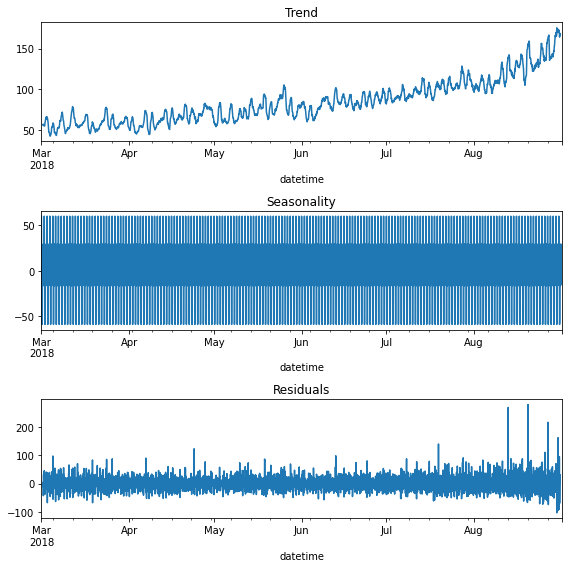

In [8]:
# Decomposition
decomposed = seasonal_decompose(data_resampled)

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

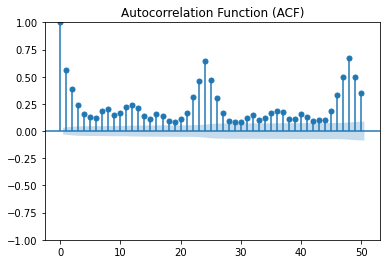

In [9]:
# ACF and PACF plots
lags_to_check = 50
plot_acf(x=train, lags=lags_to_check)
plt.title('Autocorrelation Function (ACF)')
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


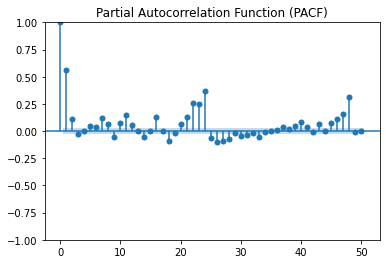

In [10]:
lags_to_check = 50 
plot_pacf(x=train, lags=lags_to_check)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [11]:
# AR Model
mod = ar_select_order(endog=train, maxlag=30)
ar_order = mod.ar_lags
print("Lags that define the AR model order:", ar_order)

ar_model = AutoReg(train, lags=ar_order)
ar_model = ar_model.fit() 



Lags that define the AR model order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


The list suggests that the AR model is considering information from the past 28 hours to make predictions for the current time point. These lags are considered important for capturing the temporal patterns in the data and making accurate predictions based on historical values.

In [12]:

# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_pred = ar_model.predict(start=start_value, end=end_value, dynamic=False)
# evaluate model
ar_mae_value = mean_absolute_error(test, ar_pred) 
print(ar_mae_value.round(3))


56.193


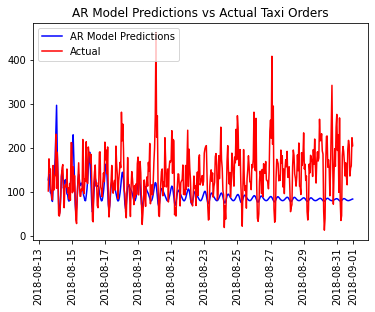

In [13]:
# Plot AR Model Results
plt.plot(ar_pred, color='blue', label='AR Model Predictions')
plt.plot(test, color='red', label='Actual')
plt.legend(loc="upper left")
plt.xticks(rotation=90)
plt.title('AR Model Predictions vs Actual Taxi Orders')
plt.show() 


The graph allows you to visually assess how well the AR model predictions align with the actual taxi order values. Ideally, we would want the blue line (AR Model Predictions) to closely follow the red line (Actual Taxi Orders), indicating accurate predictions. Any deviations or patterns in the differences between the lines can provide insights into the model's performance and areas where it may struggle to make accurate predictions. According to this graph the AR model struggled to make accurate predictions.

## Training

In [14]:
# SARIMA Model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.get_forecast(steps=len(test)).predicted_mean


In [15]:
# Exponential Smoothing Model
exp_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=24)
exp_fit = exp_model.fit()
exp_pred = exp_fit.forecast(steps=len(test))

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_train, y_train = (
    np.arange(len(train)).reshape(-1, 1),
    train.values
)
rf_model.fit(X_train, y_train)
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
rf_pred = rf_model.predict(X_test)

In [17]:
# ARIMA model
ar_order = 1
diff_order = 1
ma_order = 1
arima_full_order = (ar_order, diff_order, ma_order)

arima_model = ARIMA(train, order=arima_full_order)
arima_fit = arima_model.fit()

In [18]:
# Make predictions for ARIMA model
arima_pred = arima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)


In [19]:
# Evaluate models
sarima_rmse = mean_squared_error(test, sarima_pred, squared=False)
exp_rmse = mean_squared_error(test, exp_pred, squared=False)
rf_rmse = mean_squared_error(test, rf_pred, squared=False)
arima_rmse = mean_squared_error(test, arima_pred, squared=False)


In [20]:
# Compare RMSE values
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"Exponential Smoothing RMSE: {exp_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"ARIMA RMSE: {arima_rmse}")

SARIMA RMSE: 44.46063178080969
Exponential Smoothing RMSE: 41.20988669160317
Random Forest RMSE: 63.776695799871305
ARIMA RMSE: 64.32847055717161


In [21]:
# ARIMA Model
res = arma_order_select_ic(y=train, max_ar=0, max_ma=10)
ma_order = res.bic_min_order[1]
print("Optimal order for MA model:", res.bic_min_order)

ma_model = ARIMA(train, order=(0, 0, ma_order))
ma_model = ma_model.fit() 


Optimal order for MA model: (0, 8)


The optimal order (0, 8) suggests that, for the specific time series being analyzed, the most effective ARIMA model includes no autoregressive terms but includes information from the previous 8 time points in the moving average component to make predictions.

In [22]:
# make predictions
start_value = len(train)
end_value = len(train) + len(test) - 1 
ma_pred = ma_model.predict(start=start_value, end=end_value, dynamic=False)

# calculate MAE of predictions
ma_mae_value = mean_absolute_error(test, ma_pred)
print(ma_mae_value)

68.22641349689644


In [23]:
# Stationarity Test
data_stationarityTest = adfuller(train, autolag='AIC')
print("P-value from ADF test: ", data_stationarityTest[1])

P-value from ADF test:  0.0007322730527364293


The p-value returned by the test is less than 0.05, it’s very likely that the dataset is stationary. 

In [24]:
# ARIMA Model
ar_order = 1
diff_order = 1
ma_order = 1
arima_full_order = (ar_order, diff_order, ma_order)

arima_model = ARIMA(train, order=arima_full_order)
arima_model = arima_model.fit()

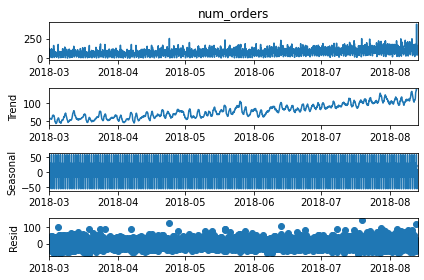

In [25]:
# Decomposition Plot
decomposition = seasonal_decompose(train)
decomposition.plot()
plt.show()


## Testing

In [26]:
# Choose the best model
best_model = min(sarima_rmse, exp_rmse, rf_rmse, arima_rmse)

if best_model == sarima_rmse:
    final_model = sarima_fit
    final_pred = sarima_fit.get_forecast(steps=1).predicted_mean.values[0]
elif best_model == exp_rmse:
    final_model = exp_fit
    final_pred = exp_fit.forecast(steps=1).values[0]
elif best_model == rf_rmse:
    final_model = rf_model
    final_pred = rf_model.predict(np.array([[len(train)]]))[0]
else:
    final_model = arima_fit
    final_pred = arima_fit.predict(start=len(train), end=len(train), dynamic=False)[0]

print(f"Predicted number of taxi orders for the next hour: {round(final_pred)}")

Predicted number of taxi orders for the next hour: 117


Best-performing model: HoltWintersResultsWrapper


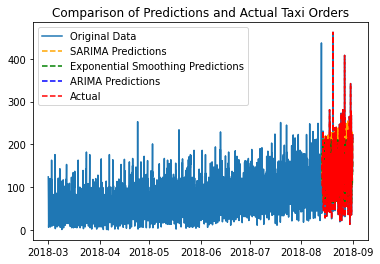

In [27]:
# Print results
print(f"Best-performing model: {type(final_model).__name__}")

# Plot results
plt.plot(data_resampled, label='Original Data')
plt.plot(sarima_pred, label='SARIMA Predictions', linestyle='dashed', color='orange')
plt.plot(exp_pred, label='Exponential Smoothing Predictions', linestyle='dashed', color='green')
plt.plot(arima_pred, label='ARIMA Predictions', linestyle='dashed', color='blue')  
plt.plot(test, label='Actual', linestyle='dashed', color='red')
plt.legend()
plt.title('Comparison of Predictions and Actual Taxi Orders')
plt.show()

In conclusion, the best performing model is ExponentialSmoothing model which RSME is 41.20988669160317 and the lowest among other model. Moreover, the predicted number of taxi orders for the next hour is 117.